# Supervised Machine Learning Models for Music Genre Classification

In [31]:
import pandas as pd

df = pd.read_csv('Data/features_3_sec.csv')

### Preprocess Data

In [32]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Selecting target column as music genre (already named label) 
X = df.drop(columns=['label', 'filename'])
y = df['label']

# Standardize 
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [33]:
from sklearn.model_selection import train_test_split
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=random_state)

### Initialize Models

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

models = {
    'Random Forest': RandomForestClassifier(n_estimators=1000, random_state=random_state),
    'SVM': SVC(random_state=random_state),
    'KNN': KNeighborsClassifier(n_neighbors=10),
    'Decision Tree': DecisionTreeClassifier(random_state=random_state),
    'XGB': XGBClassifier(random_state=random_state)
}

In [35]:
from sklearn.metrics import classification_report, accuracy_score

# Method to briefly assess models based primarily on accuracy
def model_assess(model):
    # Train and make predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(model)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

### Assess Models

In [36]:
for model_name, model in models.items():
    print(f'Evaluating model: {model_name}')
    model_assess(model)

Evaluating model: Random Forest
[CV 2/3] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=13, n_estimators=150, reg_lambda=0;, score=0.661 total time=   3.0s
[CV 3/3] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=13, n_estimators=150, reg_lambda=0;, score=0.646 total time=   2.3s
[CV 2/3] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=50, reg_lambda=0.1;, score=0.843 total time=   3.1s
[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=19, min_child_weight=3, n_estimators=250, reg_lambda=0.1;, score=0.860 total time=   5.2s
[CV 3/3] END colsample_bytree=0.6, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=3, n_estimators=100, reg_lambda=1.0;, score=0.872 total time=   5.3s
[CV 3/3] END colsample_bytree=0.6, gamma=0, learning_rate=0.2, max_depth=11, min_child_weight=2, n_estimators=100, reg_lambda=1.0;, score=0.868 total tim

In [37]:
# Best model was XGB

xgb_clf = XGBClassifier(random_state=random_state)

### Tune Hyperparameters of Best Model

In [38]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_grid = {
    'n_estimators': np.arange(50, 301, 50),
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': np.arange(3, 21, 2),
    'min_child_weight': np.arange(1, 21, 2),
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_lambda': [0, 0.1, 0.5, 1.0]
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=XGBClassifier(random_state=random_state), param_distributions=param_grid, 
                                   n_iter=100, cv=3, verbose=2, random_state=random_state, n_jobs=-1)
random_search.fit(X_train, y_train)
best_params_random = random_search.best_params_
print(f"Best parameters found by RandomizedSearchCV: {best_params_random}")


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found by RandomizedSearchCV: {'subsample': 0.8, 'reg_lambda': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.6}


In [39]:
from sklearn.model_selection import GridSearchCV

# Redefine parameter grid for GridSearchCV based on RandomizedSearchCV results
param_grid_refined = {
    'n_estimators': [best_params_random['n_estimators']],
    'learning_rate': [best_params_random['learning_rate']],
    'max_depth': [best_params_random['max_depth'] - 1, best_params_random['max_depth'], best_params_random['max_depth'] + 1],
    'min_child_weight': [best_params_random['min_child_weight'] - 1, best_params_random['min_child_weight'], best_params_random['min_child_weight'] + 1],
    'subsample': [best_params_random['subsample']],
    'colsample_bytree': [best_params_random['colsample_bytree']],
    'gamma': [best_params_random['gamma']],
    'reg_lambda': [best_params_random['reg_lambda']],
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=XGBClassifier(random_state=random_state), param_grid=param_grid_refined, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params_grid = grid_search.best_params_
print(f"Best parameters found by GridSearchCV: {best_params_grid}")

# Best estimator from GridSearchCV
best_xgb_model = grid_search.best_estimator_


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters found by GridSearchCV: {'colsample_bytree': 0.6, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 300, 'reg_lambda': 0, 'subsample': 0.8}


### Evaluate Model

In [40]:
xgb_clf_tuned = XGBClassifier(**best_params_grid, random_state=random_state)

In [41]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

def complete_model_evaluation(model, model_name):
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Cross-Validation Scores: {cv_scores}")
    print(f"Mean CV Score: {cv_scores.mean():.4f}")
    print(f"Standard Deviation CV Score: {cv_scores.std():.4f}")
    
    # Train and make predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate and print accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name} Model')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Cross-Validation Scores: [0.89180738 0.88555347 0.87797247 0.89612015 0.89111389]
Mean CV Score: 0.8885
Standard Deviation CV Score: 0.0063
Accuracy: 0.9089
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       208
           1       0.94      0.98      0.96       203
           2       0.79      0.89      0.84       186
           3       0.88      0.91      0.89       199
           4       0.96      0.89      0.93       218
           5       0.88      0.90      0.89       192
           6       0.94      0.96      0.95       204
           7       0.97      0.96      0.96       180
           8       0.92      0.90      0.91       211
           9       0.91      0.83      0.86       197

    accuracy                           0.91      1998
   macro avg       0.91      0.91      0.91      1998
weighted avg       0.91      0.91      0.91      1998


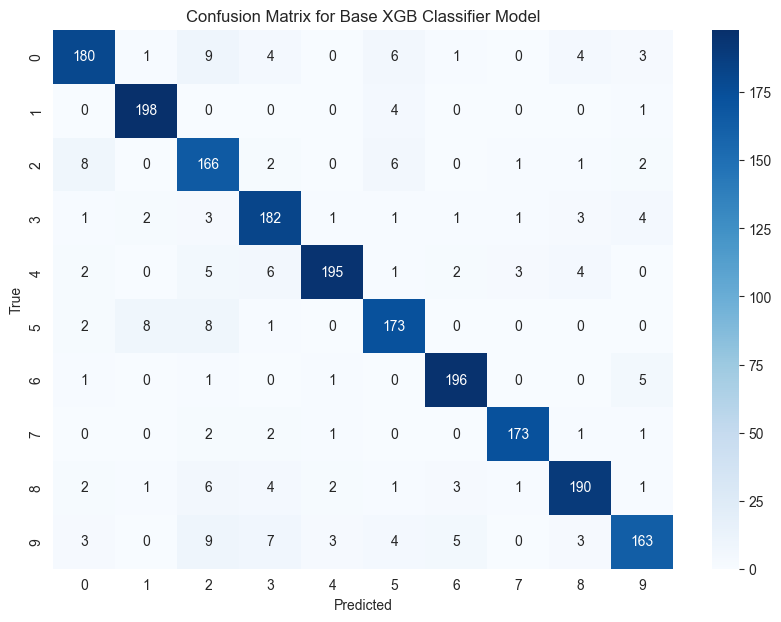

In [42]:
complete_model_evaluation(xgb_clf, "Base XGB Classifier")

Cross-Validation Scores: [0.88868043 0.88305191 0.86921151 0.89236546 0.88548185]
Mean CV Score: 0.8838
Standard Deviation CV Score: 0.0079
Accuracy: 0.9109
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       208
           1       0.95      0.99      0.97       203
           2       0.82      0.90      0.86       186
           3       0.89      0.89      0.89       199
           4       0.95      0.89      0.91       218
           5       0.92      0.93      0.92       192
           6       0.93      0.97      0.95       204
           7       0.96      0.95      0.95       180
           8       0.91      0.90      0.91       211
           9       0.86      0.81      0.83       197

    accuracy                           0.91      1998
   macro avg       0.91      0.91      0.91      1998
weighted avg       0.91      0.91      0.91      1998


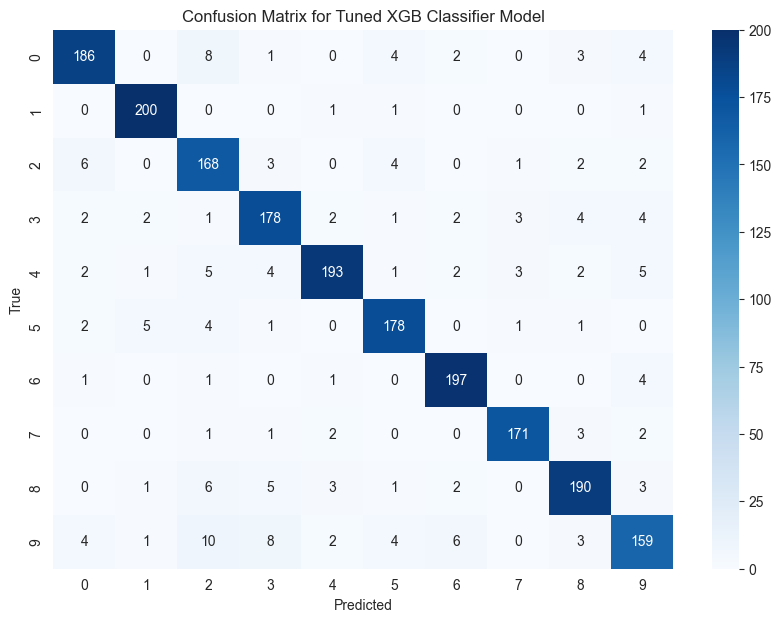

In [43]:
complete_model_evaluation(xgb_clf_tuned, "Tuned XGB Classifier")